<a href="https://colab.research.google.com/github/amanvishnani/CSCI-5409-A2/blob/master/Adv_Cloud_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Aman Vishnani

B00#: B00840115

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
import random

In [0]:
GB = 1000
TB = 1_000_000
PB = 1_000_000_000

# Class Defination

In [0]:
class Task:
  """
  Task
  A Task has a certain resource requirements to run.


  memory: in MegaBytes default 1GB
  storage: in MegaBytes default 10GB
  pe: process executors count default 1
  """
  def __init__(self, user, memory=1_000, storage=10_000, pe=1):
    self.memory = memory
    self.storage = storage
    self.pe = pe
    if user is None:
      raise Exception("User is None")
    self.user = user
    user.tasks.append(self)

In [0]:
class User:
  """User defines the type of user (public, private, hibrid)
  User has a User_ID, some VMs allocated to it and tasks(requests) which 
  consume the resources. It also have some factor by which resources are scaled.
  """
  id_count = 0
  def __init__(self, user_type="public", auto_scale_factor=None):
    User.id_count = User.id_count + 1
    self.user_id = User.id_count
    self.user_type = user_type
    self.vms = []
    self.tasks = []
    self.history  = {"avail_mem": [], "avail_storage":[], "avail_pe":[],
                     "total_mem": [], "total_storage":[], "total_pe":[],
                     "used_mem": [], "used_storage":[], "used_pe": []}

    if (user_type is "public" or user_type is "hybrid") and auto_scale_factor is not None:
      raise Exception("Only Private Users can configure auto_scale_factor")
      return
    
    if user_type is "hybrid":
      self.auto_scale_factor = 0.6
    elif user_type is "private" and auto_scale_factor is None:
      self.auto_scale_factor = 0.6
    else:
      self.auto_scale_factor = auto_scale_factor

  def get_available_resources(self):
    (total_mem, total_storage, total_pe) = self.get_total_resources()
    (used_mem, used_storage, used_pe) = self.get_used_resources()
    return (total_mem - used_mem, total_storage - used_storage, total_pe - used_pe)

  def get_used_resources(self):
    mem = 0;
    storage = 0
    pe = 0
    for task in self.tasks:
      mem += task.memory
      storage += task.storage
      pe += task.pe
    return (mem, storage, pe)

  def get_total_resources(self):
    mem = 0;
    storage = 0
    pe = 0
    for vm in self.vms:
      mem += vm.memory
      storage += vm.storage
      pe += vm.pe
    return (mem, storage, pe)

  def can_run_task(self, mem, storage, pe):
    (avail_mem, avail_storage, avail_pe) = self.get_available_resources()
    # print("USED",self.get_used_resources())
    # print("TOTAL",self.get_total_resources())
    if avail_mem < mem:
      print("Available memory(",avail_mem,"MB) is less than requested memory (", mem, "MB)")
    elif avail_storage < storage:
      print("Available storage(",avail_storage,"MB) is less than requested storage (", storage, "MB)")
    elif avail_pe < pe:
      print("Available Executors(",avail_pe,") is less than requested Executors(", pe, ")")
    return (avail_mem >= mem and avail_storage >= storage and avail_pe >= pe)

  def scale_resources(self, data_center):
    if self.auto_scale_factor is None:
      raise Exception("Auto Scale factor is None or User is Public-User")
    (mem, storage, pe) = self.get_total_resources()
    vm = Vm(self, (mem/self.auto_scale_factor)-mem, 
            (storage/self.auto_scale_factor)-storage,
            (pe/self.auto_scale_factor)-pe)
    print(f"Scaling Resources for User_ID:{self.user_id} User_Type:'{self.user_type}' by Scale Factor: {self.auto_scale_factor}")
    print(f"VM Configuration:{vm}")
    # print("USED",self.get_used_resources())
    # print("TOTAL",self.get_total_resources())

  def update_history(self):
    (total_mem, total_storage, total_pe) = self.get_total_resources()
    (avail_mem, avail_storage, avail_pe) = self.get_available_resources()
    (used_mem, used_storage, used_pe) = self.get_used_resources()
    self.history["total_mem"].append(total_mem)
    self.history["total_storage"].append(total_storage)
    self.history["total_pe"].append(total_pe)

    self.history["avail_mem"].append(avail_mem)
    self.history["avail_storage"].append(avail_storage)
    self.history["avail_pe"].append(avail_pe)
    
    self.history["used_mem"].append(used_mem)
    self.history["used_storage"].append(used_storage)
    self.history["used_pe"].append(used_pe)
    
  def plot_graph(self):
    plt.plot(self.history["total_mem"], linestyle='-', color='g', label='Total Memory')
    plt.plot(self.history["used_mem"], linestyle=':', color='g', label='Used Memory')
    plt.plot(self.history["total_storage"], linestyle='-', color='b', label='Total Storage')
    plt.plot(self.history["used_storage"], linestyle=':', color='b', label='Used Storage')
    plt.legend(loc='best')
    plt.figure()
    plt.plot(self.history["total_pe"], linestyle='-', color='r', label='Total PE')
    plt.plot(self.history["used_pe"], linestyle=':', color='r', label='Used PE')
    plt.legend(loc='best')

In [0]:
class Vm:
  """
  memory: in MegaBytes default 1GB
  storage: in MegaBytes default 10GB
  pe: process executors count default 1
  """
  def __init__(self, user, memory=1_000, storage=10_000, pe=1):
    self.memory = memory
    self.storage = storage
    self.pe = pe
    if user is None:
      raise Exception("User is None")
    self.user = user
    user.vms.append(self)

  def __str__(self):
    return f"[Memory: {self.memory}MB, Storage: {self.storage}MB, PE:{self.pe}]"

In [0]:
class DataCenter:
  """
  DataCenter defines the maximum capacity a cloud can have.

  
  memory: in MegaBytes default 100TB
  storage: in MegaBytes default 10PB
  pe: process executors count default 10000
  """
  def __init__(self, memory=100_000_000, storage=10_000_000_000, pe=10_000):
    self.memory = memory
    self.storage = storage
    self.pe = pe
    return

  def get_vm(self, memory, storage, pe, user):
    if memory > self.memory:
      raise Exception("Cannot Allocate VM, not enough Memory in DataCenter")
    if storage > self.storage:
      raise Exception("Cannot Allocate VM, not enough Storage in DataCenter")
    if pe > self.pe:
      raise Exception("Cannot Allocate VM, not enough PE in DataCenter")
    self.memory = self.memory - memory
    self.storage = self.storage - storage
    self.pe = self.pe - pe
    return Vm(user, memory, storage, pe)

  def get_vms(self, memory, storage, pe, user, count=1):
    all_vms = []
    try:
      for i in range(count):
        vm = self.get_vm(memory, storage, pe, user)
        all_vms.append(vm)
    except:
      print("Failed to provision all the resources.")
    return all_vms

In [0]:
class TaskRunner:
  def __init__(self, data_center):
    self.data_center = data_center
  
  def run_tasks(self, count, mem, storage, pe, user):
    tasks = []
    for i in range(count):
      while (user.can_run_task(mem=mem, storage=storage, pe=pe) is False):
        if user.user_type is "public":
          print("Resources un-available and SLA does not provide Auto Scaling")
          print("Exiting")
          return
        elif user.user_type is "private":
          user.scale_resources(self.data_center)
        else:
          (mem, storage, pe) = user.get_used_resources()
          (t_mem, t_storage, t_pe) = user.get_total_resources()
          used = max(mem/t_mem, storage/t_storage, pe/t_pe)
          print(used)
          if used >= 0.6:
            user.scale_resources(self.data_center)
            continue
          else:
            print("less than 60% of the resources are used Auto Scaling is not possible")
            return
      task = Task(user, mem, storage, pe)
      user.update_history()
      tasks.append(task)

# Public User Example

Create DataCenter with default params

In [0]:
data_center = DataCenter()

Create public user which does not have auto scale feature.

In [0]:
public_user = User(user_type="public")

Allocate VirtualMachines to that Public User with specific configuration

In [0]:
all_vms = data_center.get_vms(memory=1 * GB, storage=1 * GB, pe=1, user=public_user, count=10_000)

Assert that VMs have been allocated

In [0]:
len(all_vms)

10000

Check if DataCenter has any free Process Executors

In [0]:
data_center.pe

0

List out all the resources available to the user 

Format: (memory, storage, process executors) in Mega Bytes

In [0]:
public_user.get_available_resources()

(10000000, 10000000, 10000)

Create TaskRunner object which will run tasks and scale VMs if SLA provides auto scaling and the data center has the resources available for scaling

In [0]:
runner = TaskRunner(data_center)

Run 500 tasks with given configuration.

In [0]:
runner.run_tasks(count=500, mem=1*GB, storage=5*GB, pe=2, user=public_user)

Check available resources after few tasks have been assigned.

In [0]:
public_user.get_available_resources()

(9500000, 7500000, 9000)

In [0]:
runner.run_tasks(count=1500, mem=1*GB, storage=5*GB, pe=2, user=public_user)

In [0]:
public_user.get_available_resources()

(8000000, 0, 6000)

In [0]:
public_user.get_used_resources()

(2000000, 10000000, 4000)

In [0]:
runner.run_tasks(count=1, mem=1*GB, storage=1*GB, pe=2, user=public_user)

Available storage( 0 MB) is less than requested storage ( 1000 MB)
Resources un-available and SLA does not provide Auto Scaling
Exiting


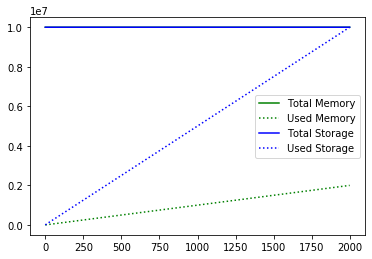

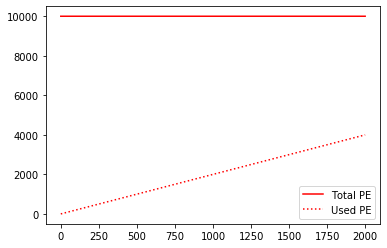

In [0]:
public_user.plot_graph()

# Private User Example

In [0]:
 data_center = DataCenter()

In [0]:
private_user = User(user_type="private")

In [0]:
all_vms = data_center.get_vms(memory=1 * GB, storage=5 * GB, pe=1, user=private_user, count=1000)

In [0]:
runner = TaskRunner(data_center)
for i in range(1000):
  runner.run_tasks(count=1, mem=random.random()*GB, storage=random.random()*2*GB, pe=random.randint(1,3), user=private_user)

Available Executors( 0 ) is less than requested Executors( 3 )
Scaling Resources for User_ID:2 User_Type:'private' by Scale Factor: 0.6
VM Configuration:[Memory: 666666.6666666667MB, Storage: 3333333.333333334MB, PE:666.6666666666667]
Available Executors( 0.6666666666667425 ) is less than requested Executors( 2 )
Scaling Resources for User_ID:2 User_Type:'private' by Scale Factor: 0.6
VM Configuration:[Memory: 1111111.1111111112MB, Storage: 5555555.555555556MB, PE:1111.111111111111]


In [0]:
private_user.get_used_resources()

(492946.3435544279, 964451.586670997, 2001)

In [0]:
private_user.get_available_resources()

(2284831.43422335, 12924437.302217893, 776.7777777777778)

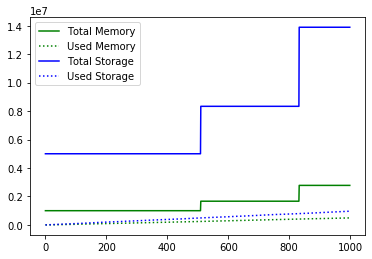

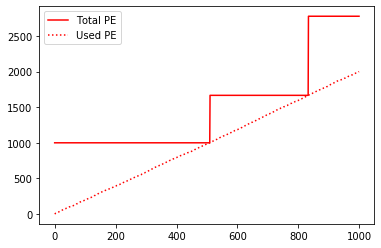

In [0]:

private_user.plot_graph()

# Hybrid User

In [0]:
 data_center = DataCenter()

In [0]:
hybrid_user = User(user_type="hybrid")

In [0]:
hybrid_user.user_id

3

In [0]:
all_vms = data_center.get_vms(memory=1 * GB, storage=5 * GB, pe=1, user=hybrid_user, count=1000)

In [0]:
runner = TaskRunner(data_center)
for i in range(1000):
  runner.run_tasks(count=1, mem=random.random()*GB, storage=random.random()*2*GB, pe=2, user=hybrid_user)

Available Executors( 0 ) is less than requested Executors( 2 )
1.0
Scaling Resources for User_ID:3 User_Type:'hybrid' by Scale Factor: 0.6
VM Configuration:[Memory: 666666.6666666667MB, Storage: 3333333.333333334MB, PE:666.6666666666667]
Available Executors( 666.6666666666667 ) is less than requested Executors( 1000 )
0.6
Scaling Resources for User_ID:3 User_Type:'hybrid' by Scale Factor: 0.6
VM Configuration:[Memory: 1111111.1111111112MB, Storage: 5555555.555555556MB, PE:1111.111111111111]
Available Executors( 1.7777777777778283 ) is less than requested Executors( 2 )
0.99936
Scaling Resources for User_ID:3 User_Type:'hybrid' by Scale Factor: 0.6
VM Configuration:[Memory: 1851851.8518518526MB, Storage: 9259259.25925926MB, PE:1851.8518518518517]
Available Executors( 1853.6296296296296 ) is less than requested Executors( 2776 )
0.599616
less than 60% of the resources are used Auto Scaling is not possible


In [0]:
len(hybrid_user.history['total_storage'])

999

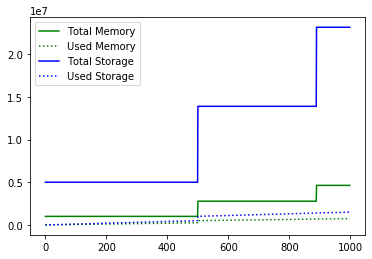

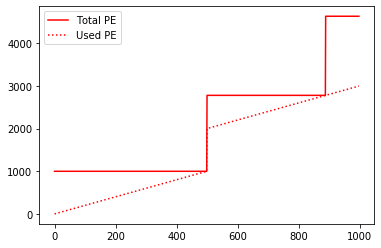

In [0]:
hybrid_user.plot_graph()